# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


#### Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



##### 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [40]:
import json
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import re

TRAINT_PATH = 'data/train.jsonl'
DEV_PATH = 'data/dev.jsonl'
TEST_PATH = 'data/test.jsonl'

In [41]:
def read_jsonl(path, lines_count = None):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if lines_count is not None and i >= lines_count:
                break
            line = line.strip()
            if not line:
                continue
            data.append(json.loads(line))
    return data

def parse_entity_type(ent_str):
    parts = ent_str.split("\t")
    type_and_span = parts[1].split()
    return type_and_span[0]

def parse_relation_type(rel_str):
    parts = rel_str.split("\t", 1)
    rest = parts[1].strip()
    return rest.split()[0]

def get_stats(rows, top=15):
    texts_lengths = []
    entities_per_doc = []
    ent_freq = Counter()
    rel_freq = Counter()
    for row in rows:
        texts_lengths.append(len(re.findall(r"\S+", row["text"])))
        entities_per_doc.append(len(row["entities"]))
        for e in row["entities"]:
            ent_freq[parse_entity_type(e)] += 1
        for rel in row["relations"]:
            rel_freq[parse_relation_type(rel)] += 1    
    return {
        "top_entities": ent_freq.most_common(top),
        "top_relations": rel_freq.most_common(top),
        "texts_lengths": texts_lengths,
        "entities_per_doc": entities_per_doc
    }

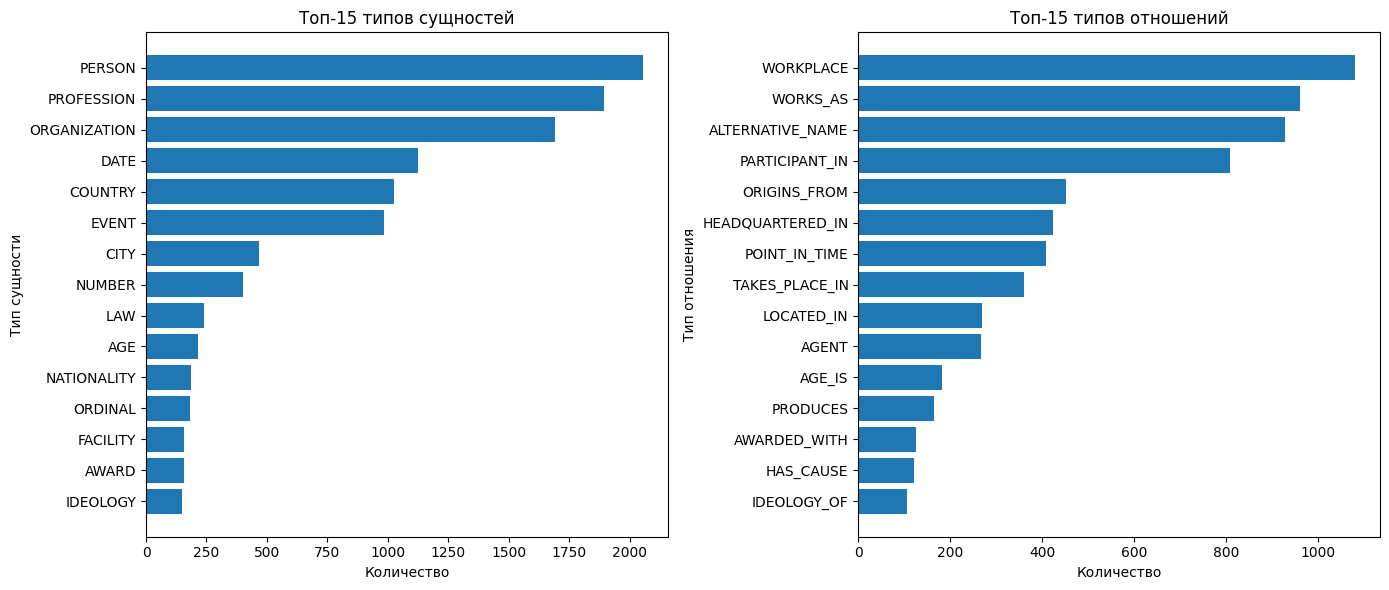

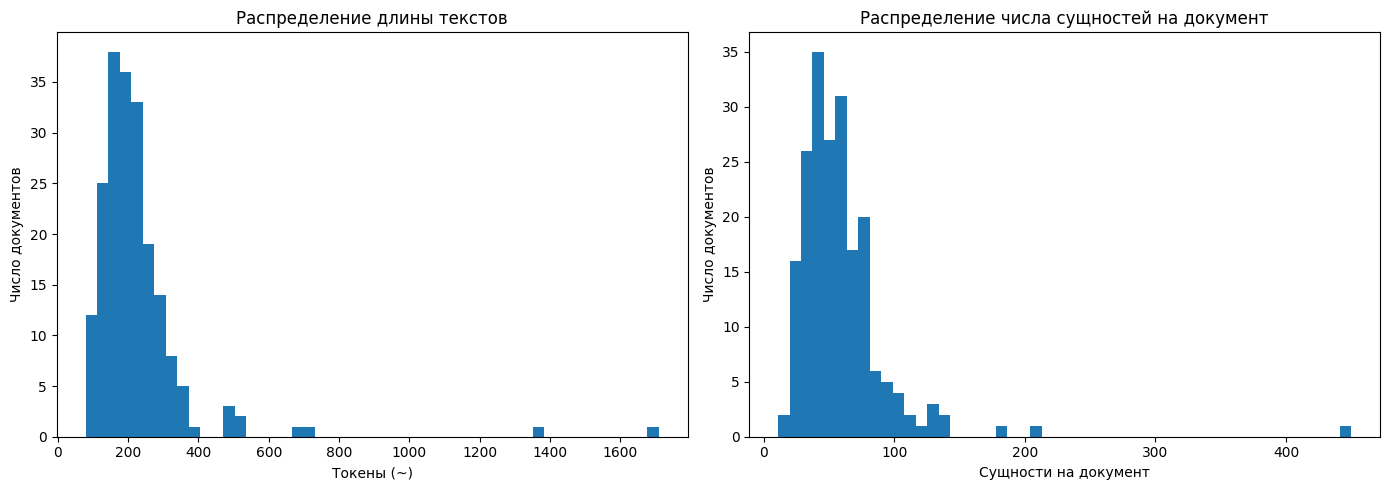

In [42]:
rows = read_jsonl(TRAINT_PATH, 200)
stats = get_stats(rows)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
labels_e = [t for t, _ in stats["top_entities"]][::-1]
values_e = [c for _, c in stats["top_entities"]][::-1]
axes[0].barh(labels_e, values_e)
axes[0].set_title("Топ-15 типов сущностей")
axes[0].set_xlabel("Количество")
axes[0].set_ylabel("Тип сущности")

labels_r = [t for t, _ in stats["top_relations"]][::-1]
values_r = [c for _, c in stats["top_relations"]][::-1]
axes[1].barh(labels_r, values_r)
axes[1].set_title("Топ-15 типов отношений")
axes[1].set_xlabel("Количество")
axes[1].set_ylabel("Тип отношения")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(stats["texts_lengths"], bins=50)
axes[0].set_title("Распределение длины текстов")
axes[0].set_xlabel("Токены (~)")
axes[0].set_ylabel("Число документов")

axes[1].hist(stats["entities_per_doc"], bins=50)
axes[1].set_title("Распределение числа сущностей на документ")
axes[1].set_xlabel("Сущности на документ")
axes[1].set_ylabel("Число документов")

plt.tight_layout()
plt.show()


По выборке из 200 строк и построенным графикам можно сделать следующие выводы:
1) По частотам сущностей и отношений видно, что присутствует дисбаланс классов. При моделировании можно ожидать, что редкие типы будут хуже по F1.
2) Большинство текстов относительно короткие, но есть очень длинные. Это значит, что часть текстов может обрезаться, нужно будет это учитывать
3) По количеству сущностей видно, что в некоторых документах очень большое число сущностей, что может создавать сложные примеры для NER

##### Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [43]:

import re
from collections import Counter
from typing import List, Dict, Any, Tuple, Optional

# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}

def overlaps(a_start, a_end, b_start, b_end):
    return max(a_start, b_start) < min(a_end, b_end)

def bio_tags(tokens, spans, entities):
    tags = ["O"] * len(tokens)
    entities_sorted = sorted(entities, key=lambda e: (e["start"], -(e["end"] - e["start"])))
    for ent in entities_sorted:
        s, e, t = ent["start"], ent["end"], ent["type"]
        idxs = [i for i, (ts, te) in enumerate(spans) if overlaps(ts, te, s, e)]
        if not idxs:
            continue
        if any(tags[i] != "O" for i in idxs):
            continue
        tags[idxs[0]] = f"B-{t}"
        for i in idxs[1:]:
            tags[i] = f"I-{t}"

    return tags

def word_tokenize_with_spans(text):
    tokens = text.split()
    spans = []
    cursor = 0
    for tok in tokens:
        idx = text.find(tok, cursor)
        start = idx
        end = idx + len(tok)
        spans.append((start, end))
        cursor = end
    return tokens, spans

def build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]:
    event2id = {e: i for i, e in enumerate(event_list)}
    examples: List[dict] = []

    for rec in records:
        text = rec["text"]
        tokens, token_spans = word_tokenize_with_spans(text)
        entities = []
        for line in rec.get("entities", []):
            pe = parse_entity_line(line)
            if pe:
                entities.append(pe)
        tags = bio_tags(tokens, token_spans, entities)
        cls_vec = [0] * len(event_list)
        for line in rec.get("relations", []):
            pr = parse_relation_line(line)
            if pr and pr.get("type") in event2id:
                cls_vec[event2id[pr["type"]]] = 1
        examples.append({
            "text": text,
            "tokens": tokens,
            "token_spans": token_spans,
            "tags": tags,
            "cls_vec": cls_vec,
        })

    return examples

def make_event_list(records, K=30):
    cnt = Counter()
    for rec in records:
        for line in rec.get("relations", []):
            pr = parse_relation_line(line)
            if pr and pr.get("type"):
                cnt[pr["type"]] += 1
    return [t for t, _ in cnt.most_common(K)], cnt

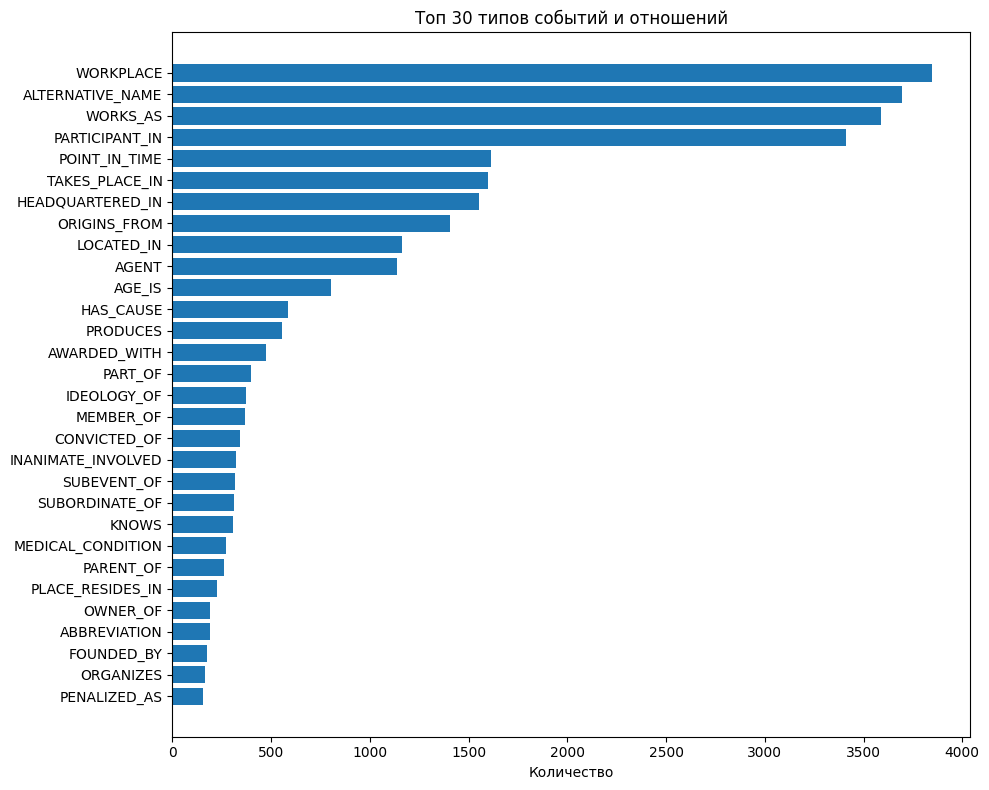

In [44]:
records_train = read_jsonl(TRAINT_PATH)
event_list, relations_counter = make_event_list(records_train, K=30)

top = relations_counter.most_common(30)
labels = [t for t, _ in top][::-1]
values = [c for _, c in top][::-1]
plt.figure(figsize=(10, 8))
plt.barh(range(len(labels)), values)
plt.yticks(range(len(labels)), labels)
plt.title("Топ 30 типов событий и отношений")
plt.xlabel("Количество")
plt.tight_layout()
plt.show()

In [45]:
import random

def sanity_check_examples(examples, event_list, n=5, seed=42, max_text_chars=400, max_tokens=80):
    rnd = random.Random(seed)
    idxs = rnd.sample(range(len(examples)), k=min(n, len(examples)))
    for j, idx in enumerate(idxs, 1):
        ex = examples[idx]
        text = ex["text"]
        tokens = ex["tokens"]
        tags = ex["tags"]
        cls_vec = ex["cls_vec"]
        active = [event_list[i] for i, v in enumerate(cls_vec) if v == 1]
        print("=" * 100)
        print(f"Пример #{j} (idx={idx})")
        print("-Текст:")
        snippet = text[:max_text_chars].replace("\n", "\\n")
        print(snippet + ("…" if len(text) > max_text_chars else ""))
        print("\n- Отношения:", active if active else "[]")
        print("- cls_vec:", cls_vec)
        print("\n- Tokens / BIO:")
        n_show = min(max_tokens, len(tokens))
        for i in range(n_show):
            tok = tokens[i]
            tag = tags[i]
            print(f"{i:03d}\t{tok}\t{tag}")

        if len(tokens) > n_show:
            print(f"... ({len(tokens) - n_show} еще токенов)")

examples_train = build_examples_from_nerel(records_train, event_list)
sanity_check_examples(examples_train, event_list, n=5, seed=42)

Пример #1 (idx=654)
-Текст:
Две лесбиянки со взрослым сыном из России поженились и попросили политического убежища в Аргентине\nВ день четырёхлетия принятия закона об однополом браке в Аргентине — 15 июля 2014 года, в Буэнос-Айресе две российские лесбиянки — Марина Миронова и Оксана Тимофеева, воспитывающие 16-летноего сына, поженились и пропросили политического убежища в этой стране.\nОб этом ообщает агентство EFE со ссылкой …

- Отношения: ['WORKPLACE', 'ALTERNATIVE_NAME', 'WORKS_AS', 'PARTICIPANT_IN', 'POINT_IN_TIME', 'TAKES_PLACE_IN', 'HEADQUARTERED_IN', 'ORIGINS_FROM', 'LOCATED_IN', 'AGENT', 'AGE_IS', 'MEMBER_OF', 'INANIMATE_INVOLVED', 'ABBREVIATION']
- cls_vec: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

- Tokens / BIO:
000	Две	B-NUMBER
001	лесбиянки	B-EVENT
002	со	O
003	взрослым	O
004	сыном	O
005	из	O
006	России	B-COUNTRY
007	поженились	O
008	и	O
009	попросили	O
010	политического	O
011	убежища	O
012	в	O
013	Аргентине	B-COUNTRY
014	

##### 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.



In [46]:
from transformers import AutoTokenizer

model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [47]:
def tokenize_and_align_labels(examples, tokenizer, label2id, max_length):
    input_ids_list = []
    attention_mask_list = []
    labels_list = []
    cls_labels_list = []

    for ex in examples:
        words = ex["tokens"]
        word_tags = ex["tags"]
        cls_vec = ex["cls_vec"]

        enc = tokenizer(
            words,
            is_split_into_words=True,
            return_offsets_mapping=True,
            truncation=True,
            max_length=max_length,
            padding="max_length",
            return_attention_mask=True,
        )

        word_ids = enc.word_ids()
        labels = []
        prev_word_id = None

        for word_id in word_ids:
            if word_id is None:
                labels.append(-100)
            elif word_id != prev_word_id:
                tag = word_tags[word_id] if word_id < len(word_tags) else "O"
                labels.append(label2id.get(tag, label2id.get("O", 0)))
            else:
                labels.append(-100)
            prev_word_id = word_id
        enc.pop("offset_mapping", None)
        input_ids_list.append(enc["input_ids"])
        attention_mask_list.append(enc["attention_mask"])
        labels_list.append(labels)
        cls_labels_list.append(cls_vec)

    return {
        "input_ids": input_ids_list,
        "attention_mask": attention_mask_list,
        "labels": labels_list,
        "cls_labels": cls_labels_list,
    }

def check_tokenize_and_align_labels(example, tokenized_item, tokenizer, id2label, n=60):
    toks = tokenizer.convert_ids_to_tokens(tokenized_item["input_ids"])
    labs = tokenized_item["labels"]
    for i in range(min(n, len(toks))):
        lab = labs[i]
        lab_str = "IGN" if lab == -100 else id2label[lab]
        print(f"{i:03d}\t{toks[i]}\t{lab_str}")

def build_label_maps(examples):
    uniq = set()
    for ex in examples:
        for t in ex["tags"]:
            uniq.add(t)
    labels = sorted(uniq)
    if "O" in labels:
        labels.remove("O")
        labels = ["O"] + labels
    label2id = {lab: i for i, lab in enumerate(labels)}
    id2label = {i: lab for lab, i in label2id.items()}
    return label2id, id2label

label2id, id2label = build_label_maps(examples_train)
# out = tokenize_and_align_labels(examples[:1], tokenizer, label2id, max_length=256)
# item0 = {k: out[k][0] for k in out}
# check_tokenize_and_align_labels(examples[0], item0, tokenizer, id2label)

In [48]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.enc = encodings

    def __len__(self):
        return len(self.enc["input_ids"])

    def __getitem__(self, idx):
        item = {
            "input_ids": self.enc["input_ids"][idx],
            "attention_mask": self.enc["attention_mask"][idx],
            "labels": self.enc["labels"][idx],
            "cls_labels": self.enc["cls_labels"][idx],
        }
        return item

class MultiTaskCollator:
    def __init__(self, tokenizer, label_pad_token_id=-100):
        self.tokenizer = tokenizer
        self.label_pad_token_id = label_pad_token_id

    def __call__(self, features):
        cls = [f["cls_labels"] for f in features]
        to_pad = []
        for f in features:
            to_pad.append({
                "input_ids": f["input_ids"],
                "attention_mask": f["attention_mask"],
                "labels": f["labels"],
            })

        batch = self.tokenizer.pad(
            to_pad,
            padding=True,
            return_tensors="pt",
        )

        if "labels" in batch:
            lengths = batch["attention_mask"].sum(dim=1).tolist()
            labels = batch["labels"].clone()
            for i, L in enumerate(lengths):
                if L < labels.size(1):
                    labels[i, int(L):] = self.label_pad_token_id
            batch["labels"] = labels

        batch["cls_labels"] = torch.tensor(cls, dtype=torch.float)
        return batch    

In [49]:
from torch.utils.data import DataLoader

records_dev = read_jsonl(DEV_PATH)
event_list_dev, _ = make_event_list(records_dev, K=30)
examples_dev = build_examples_from_nerel(records_dev, event_list_dev)

tokenized_train = tokenize_and_align_labels(examples_train, tokenizer, label2id, max_length=256)
tokenized_dev   = tokenize_and_align_labels(examples_dev, tokenizer, label2id, max_length=256)

train_ds = Dataset(tokenized_train)
dev_ds = Dataset(tokenized_dev)

collator = MultiTaskCollator(tokenizer)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collator)
dev_loader = DataLoader(dev_ds, batch_size=8, shuffle=False, collate_fn=collator)

In [50]:
batch = next(iter(train_loader))

print("input_ids:", batch["input_ids"].shape)
print("attention_mask:", batch["attention_mask"].shape)
print("labels:", batch["labels"].shape)
print("cls_labels:", batch["cls_labels"].shape)

labels = batch["labels"]
print("labels dtype:", labels.dtype)
print("labels min/max:", labels.min().item(), labels.max().item())
print("num -100:", (labels == -100).sum().item())

cls = batch["cls_labels"]
print("cls_labels dtype:", cls.dtype)
print("cls positives per sample:", cls.sum(dim=1)[:10].tolist())

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids: torch.Size([8, 256])
attention_mask: torch.Size([8, 256])
labels: torch.Size([8, 256])
cls_labels: torch.Size([8, 30])
labels dtype: torch.int64
labels min/max: -100 57
num -100: 767
cls_labels dtype: torch.float32
cls positives per sample: [12.0, 9.0, 10.0, 18.0, 13.0, 11.0, 15.0, 11.0]


##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [51]:
import torch
import torch.nn as nn
from transformers import AutoModel

class JointModel(nn.Module):
    def __init__(self, model_name, num_token_labels, num_cls_labels, dropout=0.1, use_uncertainty_weight=False):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.token_cls = nn.Linear(hidden_size, num_token_labels)
        self.cls_cls = nn.Linear(hidden_size, num_cls_labels)
        self.use_uncertainty_weight = use_uncertainty_weight
        if self.use_uncertainty_weight:
            self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
            self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))
        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask=None, labels=None, cls_labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state

        x = self.dropout(last_hidden)
        token_logits = self.token_cls(x)

        pooled = last_hidden[:, 0, :]
        pooled = self.dropout(pooled)
        cls_logits = self.cls_cls(pooled)

        loss = None
        token_loss = None
        cls_loss = None

        if labels is not None and cls_labels is not None:
            token_loss = self.token_loss_fct(
                token_logits.view(-1, token_logits.size(-1)),
                labels.view(-1)
            )

            if cls_labels.dtype != torch.float32 and cls_labels.dtype != torch.float16 and cls_labels.dtype != torch.bfloat16:
                cls_labels = cls_labels.float()

            cls_loss = self.cls_loss_fct(cls_logits, cls_labels)

            if self.use_uncertainty_weight:
                loss_token_term = torch.exp(-2.0 * self.log_sigma_token) * token_loss + self.log_sigma_token
                loss_cls_term = torch.exp(-2.0 * self.log_sigma_cls) * cls_loss + self.log_sigma_cls
                loss = loss_token_term + loss_cls_term
            else:
                loss = token_loss + cls_loss

        return {
            "loss": loss,
            "token_loss": token_loss,
            "cls_loss": cls_loss,
            "token_logits": token_logits,
            "cls_logits": cls_logits,
        }    

##### 5. Training / Validation



##### 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


##### Заключение

Этот шаблон даёт вам чёткую дорожную карту и рабочие точки, где нужно реализовать код. В ноутбуке предоставлены только парсеры строкового формата - всё остальное вы пишете самостоятельно: токенизация/выравнивание меток, датасеты, модель, loss, тренировка и анализ.

Удачи - приступайте к реализации прямо в ноутбуке!